### Importing relevant libraries

In [95]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### Importing dataset

In [96]:
df = pd.read_csv("alldata.csv")

In [97]:
df = df.drop("Unnamed: 7", axis = 1)

In [98]:
df = df.drop(1042, axis = 0)

In [99]:
df["ZeroCross"] = df["ZERO CROSS OVER"].copy()
df = df.drop("ZERO CROSS OVER", axis =1)
df["SignalCross"] = df["SIGNAL LINE CROSSOVER"].copy()
df = df.drop("SIGNAL LINE CROSSOVER", axis = 1)
df["macdDecision"] = df["Decision"].copy()
df = df.drop("Decision", axis = 1)

### Transforming hammer variable: 0= no hammer, 1 = hammer

In [100]:
df["Hammer"] = df["Hammer"].replace("HAMMER", 1)
df["Hammer"] = df["Hammer"].fillna(0)

### Transforming Support and Resistance: support = resistance = 1 ; other = 0

In [101]:
def supportResistanceEncoding(df):
    df["Support"] = df["Support"].fillna(0)
    df["Resistance"] = df["Resistance"].fillna(0)
    df.loc[df.Support == "S", "Support"] = 1
    df.loc[df.Resistance == "R", "Resistance"] = 1

supportResistanceEncoding(df)


### Transforming Zero cross over and signal Line Crossover: sell = 0, buy = 1

In [102]:
def crossoverEncoding(df):
    df.loc[df.ZeroCross == "Buy", "ZeroCross"] = 1
    df.loc[df.SignalCross == "Buy", "SignalCross"] = 1
    df.loc[df.ZeroCross == "Sell", "ZeroCross"] = 0
    df.loc[df.SignalCross == "Sell", "SignalCross"] = 0
    
crossoverEncoding(df)

In [103]:
#dropping this column since it is not common practice to base a decision only on the two crossovers
df = df.drop("macdDecision", axis = 1)

### Finding perfect buy/sell/hold entries 
#### looking at future values, we will determine if at each entry, the best option would have been to buy/sell/hold based on the return on the investment (%)

In [104]:
# Assume zero trading cost
# 0 = hold, 1 = buy, 2 = sell
# Rule: compare today's closing and +timeframe day's closing
# We omit the first 26 days since williams%Rs are unavailable, decision value = -1
# We omit the last timeframe days since the next timeframe days closing is unavailable, decision value = -1

def perfectEntries_2(df, timeframe):
    decision = [-1 for i in range(33)]  # for the first 32 days
    currentdecision = 0

    for i in range(33, (len(df) - timeframe)):  # from 33th day to the timeframe days before the last day
        if df.iloc[i+timeframe]['Close'] > df.iloc[i]['Close']:
            if currentdecision != 1:
                currentdecision = 1
            else:
                currentdecision = 0
            decision.append(currentdecision)
            currentdecision = 1  # Make sure if next day is buy, we show it hold
        elif df.iloc[i+timeframe]['Close'] < df.iloc[i]['Close']:
            # The first sell cannot appear before buy or hold
            if decision.count(1) > 0:
                if currentdecision != 2:
                    currentdecision = 2
                else:
                    currentdecision = 0
                decision.append(currentdecision)
                currentdecision = 2  # Make sure if next day is sell, we show it hold
            else:
                currentdecision = 0
                decision.append(currentdecision)
        else:
            currentdecision = 0
            decision.append(currentdecision)
    for i in range(timeframe):
        decision.append(-1)  # for the last timeframe days

    return decision


In [105]:
# Assume zero trading cost
# 1 = buy, 0 = sell
# repeated buy/sell signal implies a hold strategy
# possibility of short selling
# we omit the first 32 days since indicators are not all available
# we omit the (last n-timeframe) days since the algorithm work by looking in the future
def perfectEntries_3(df,timeframe):
    decision = [-1 for i in range(33)] 
    
    for i in range(33,len(df) - timeframe):
        if df.iloc[i + timeframe]["Close"] > df.iloc[i]["Close"]:
            decision.append(1)
        else: 
            decision.append(0)
            
    for i in range(timeframe): #for the last timeframe days
        decision.append(-1)
    
    return decision


In [106]:
def perfectEntries_4(df,timeframe,smoother=True):
    """
    df = dataframe used
    timeframe = time looked in the future
    smoother = determine if we use the average or the exact value
    """
    decision = [-1 for i in range(33)]
    if smoother == True:
        for i in range(33,len(df) - timeframe):
            avg = np.mean(df.iloc[i:i+timeframe]['Close'])
            if df.iloc[i]['Close'] < avg:
                decision.append(1)
            else:
                decision.append(0)
        
    
    else:
        for i in range(33,len(df) - timeframe):
            if df.iloc[i]['Close'] < df.iloc[i+timeframe]['Close']:
                decision.append(1)
            else:
                decision.append(0)
    for i in range(timeframe):
        decision.append(-1)
        
    return decision
        
        

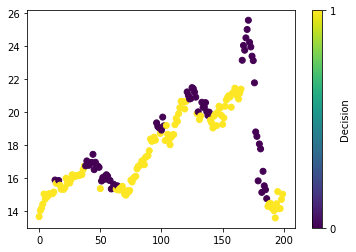

In [107]:
df['Decision14'] = perfectEntries_4(df,14)
df['Decision28'] = perfectEntries_4(df,28)
plt.scatter(range(200), df["Close"][400:600], c=df["Decision14"][400:600])
plt.colorbar(ticks = range(3), label='Decision')
# takin 14 and 28 with the smoother activated to comparw which one works better with naive bayes 
# 

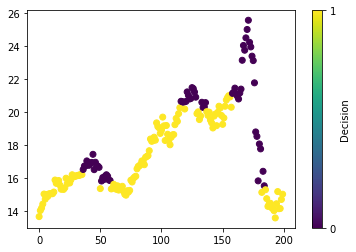

In [108]:
plt.scatter(range(200), df["Close"][400:600], c=df["Decision28"][400:600])
plt.colorbar(ticks = range(3), label='Decision')

In [109]:
# Convert willianR values to 0 = neutral, 1 = overbought, 2 = oversold
# The first 13 days are excluded, gives zero value automatically

def williamsREncoding(df):

    williamsR = [0 for i in range(13)]

    for i in range(13, len(df)):

        if df.iloc[i]['WilliamR'] < -0.2 and df.iloc[i]['WilliamR'] > -0.8:
            williamsR.append(0)
        elif df.iloc[i]['WilliamR'] >= -0.2:
            williamsR.append(1)
        else:
            williamsR.append(2)
    
    return williamsR

df.insert(11, 'Williams%R', williamsREncoding(df))


In [110]:
#df.to_csv('cleaned_data.csv', index = False)